In [ ]:
import csv
import re

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

!pip install emoji
import emoji # to remove emojies

from scipy import sparse 

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report


from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Load Data


In [ ]:
url_train_dev = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTOZ2rC82rhNsJduoyKYTsVeH6ukd7Bpxvxn_afOibn3R-eadZGXu82eCU9IRpl4CK_gefEGsYrA_oM/pub?gid=1863430984&single=true&output=tsv'
url_test = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vT-KNR9nuYatLkSbzSRgpz6Ku1n4TN4w6kKmFLkA6QJHTfQzmX0puBsLF7PAAQJQAxUpgruDd_RRgK7/pub?gid=417546901&single=true&output=tsv'

In [ ]:
from io import StringIO
import requests

def load_dataset(url):
    r = requests.get(url)
    data = r.content.decode('utf8')
    df = pd.read_csv(StringIO(data), sep='\t')
    df.columns = ['tweet', 'label']
    return df

In [ ]:
df_train_dev = load_dataset(url_train_dev)
df_test = load_dataset(url_test)

# Visualize data

In [ ]:
df_train_dev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52675 entries, 0 to 52674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   52675 non-null  object
 1   label   52675 non-null  object
dtypes: object(2)
memory usage: 823.2+ KB


In [ ]:
df_train_dev.head()

,tweet,label
0,يا من أناديها ويخنقني البكاء ويكاد صمت الدمع ...,ar
1,فيه فرق بين اهل غزة اللى مطحونين من ناحيتين وب...,ar
2,ﻋﻦ ﺍﻟﻠﺤﻈﺔ اﻟﺤﻠﻮﺓﺓ ﺍﻟﻠﻲ ﺑﺘﻐﻤﺾ ﻓﻴﻬﺎ ﻋﻴﻨﻴﻚ ﺑﺘﻔﻜﺮ ...,ar
3,يا ابو سلو عرفتني,ar
4,ب50 ريال أكفل معتمر في رمضان ، ولك بإذن الله م...,ar


In [ ]:
labels = df_train_dev.label.unique()
distribution= pd.concat(
    [pd.DataFrame(
        [[label,df_train_dev[df_train_dev['label']== label].count()[0]]], 
        columns=['labels','count']) for label in labels
     ],
     ignore_index=True).to_numpy()

distribution = np.flip(distribution[distribution[:,1].argsort()], 0)

Text(0.5, 1.0, 'Lanaguages distribution')

<Figure size 432x288 with 0 Axes>

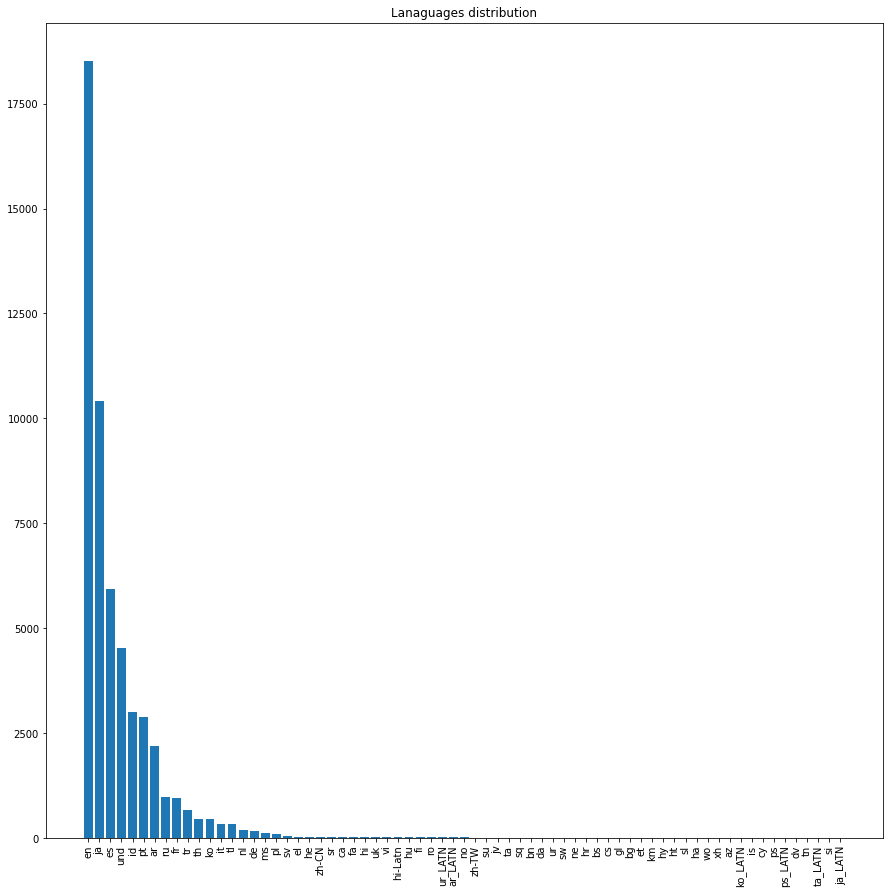

In [ ]:
font = {'size'   : 10}
plt.figure()
fig, ax = plt.subplots(figsize=(15, 15))
plt.bar(distribution[:,0], distribution[:,1])
plt.xticks(rotation=90)
plt.rc('font', **font)
plt.title('Lanaguages distribution')


Data are not uniformly distributed as there are languages with more sample than others

# Preprocessing


### Split data into train and test set

In [ ]:
# Remove lables not in train but appear in test
drop_lables = ["mr","mn","eu","lv","la","zu","yo","mk","sk"]
drop_indexes=[]
for l in drop_lables:
  drop_indexes.append(df_test[df_test["label"]==l].index.values)
drop_indexes = np.concatenate(drop_indexes)

In [ ]:
X_train = df_train_dev.tweet
y_train = df_train_dev.label
X_test = df_test.tweet
y_test = df_test.label
for index in drop_indexes:
  X_test=X_test.drop(index)
  y_test=y_test.drop(index)


### Process data 

In [ ]:
# Convert to lower case
def convert_to_lowercase(X):
  return X.str.lower()

# Removing emojies
def remove_emojies(X):
  return X.apply(lambda x: emoji.replace_emoji(x, replace=''))

def remove_urls(X):
  return X.apply(lambda x:re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", x))

# Average number of words in a sentence
def average_words(X):
  word_average = [ ((tweet.count(" ")+1) if tweet.count(".")==0 else ((tweet.count(" ")+1)/tweet.count(".")) for tweet in X)]
  scaler = MinMaxScaler()
  word_average=pd.DataFrame(word_average)
  word_average=scaler.fit_transform(word_average)
  return word_average.T

# Number of spaces in a tweet
def spaces(X):
  spaces = [ tweet.count(" ") for tweet in X]
  scaler = MinMaxScaler()
  spaces=pd.DataFrame(spaces)
  spaces=scaler.fit_transform(spaces)
  return spaces

### Encode lables

In [ ]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# Train LR model


In [ ]:
lr = Pipeline([
    ('lowercase_transformer',FunctionTransformer(convert_to_lowercase)),
    ('emojies_transformer',FunctionTransformer(remove_emojies)),
    ('url_transformer', FunctionTransformer(remove_urls)),
    ('union',FeatureUnion(
        [
            # feature average number of words
            ('average_words_transformer', FunctionTransformer(average_words)),

            # feature # of spaces
            ('spaces_transformer', FunctionTransformer(spaces)),

            # vetorize words (ignore those that appear less than 3 times)
            ("word_vectorizer", TfidfVectorizer(ngram_range=(1,3), min_df=3)),
            
            # vetorize char (ignore those that appear less than 50 times)
            ("char_vectorizer", TfidfVectorizer(analyzer='char', min_df=50,ngram_range=(3,3)))
        ]
      )
    ),
    ('logistic', LogisticRegression(solver='saga'))
])
lr.fit(X_train,y_train)

In [ ]:
y_pred=lr.predict(X_test)

In [ ]:
correct = 0

for index, prediction in enumerate(y_pred):
    if prediction == y_test[index]:
        correct +=1

print('Accuracy: ', correct/y_test.shape[0])

Accuracy:  0.8713154918959668


# Grid search

In [ ]:
grid = Pipeline([
    ('lowercase_transformer',FunctionTransformer(convert_to_lowercase)),
    ('emojies_transformer',FunctionTransformer(remove_emojies)),
    ('url_transformer', FunctionTransformer(remove_urls)),
    ('union',FeatureUnion(
        [
            # feature average number of words
            ('average_words_transformer', FunctionTransformer(average_words)),

            # feature # of spaces
            ('spaces_transformer', FunctionTransformer(spaces)),

            # vetorize words (ignore those that appear less than 3 times)
            ("word_vectorizer", TfidfVectorizer(ngram_range=(1,3), min_df=3)),
            
            # vetorize char (ignore those that appear less than 50 times)
            ("char_vectorizer", TfidfVectorizer(analyzer='char', min_df=50,ngram_range=(3,3)))
        ]
      )
    ),
    ('logistic', LogisticRegression())
])

param_grid = {
    'logistic__penalty':['l1','l2','none'],
    'logistic__solver':['saga','lbfgs']
}

grid_search = GridSearchCV(grid, param_grid, cv=10,n_jobs=5)
grid_search.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('lowercase_transformer',
                                        FunctionTransformer(func=<function convert_to_lowercase at 0x7f5cf99a5a70>)),
                                       ('emojies_transformer',
                                        FunctionTransformer(func=<function remove_emojies at 0x7f5cf9b39560>)),
                                       ('url_transformer',
                                        FunctionTransformer(func=<function remove_urls at 0x7f5cf9b39830>)),
                                       ('union',
                                        FeatureUnion(transform...
                                                                       ('spaces_transformer',
                                                                        FunctionTransformer(func=<function spaces at 0x7f5cf9b0a3b0>)),
                                                                       ('word_vectorizer',
                  

In [ ]:
grid_search.best_params_

{'logistic__penalty': 'none', 'logistic__solver': 'lbfgs'}

In [ ]:
y_pred_grid_search = grid_search.predict(X_test)

In [ ]:
correct = 0

for index, prediction in enumerate(y_pred_grid_search):
    if prediction == y_test[index]:
        correct +=1

print('Accuracy: ', correct/y_test.shape[0])

Accuracy:  0.8731247644176404


In [ ]:
print(classification_report(y_test,y_pred_grid_search))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96       529
           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         1
          10       0.87      0.82      0.85        50
          12       0.83      0.45      0.59        11
          13       0.95      0.95      0.95      4758
          14       0.93      0.95      0.94      1476
          16       0.00      0.00      0.00         5
          17       1.00      0.25      0.40         8
          18       0.87      0.90      0.89       224
          21       0.43      0.21      0.29        14
          22       0.50    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

# Confusion Matrix

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Confusion matrix')

<Figure size 2520x2520 with 0 Axes>

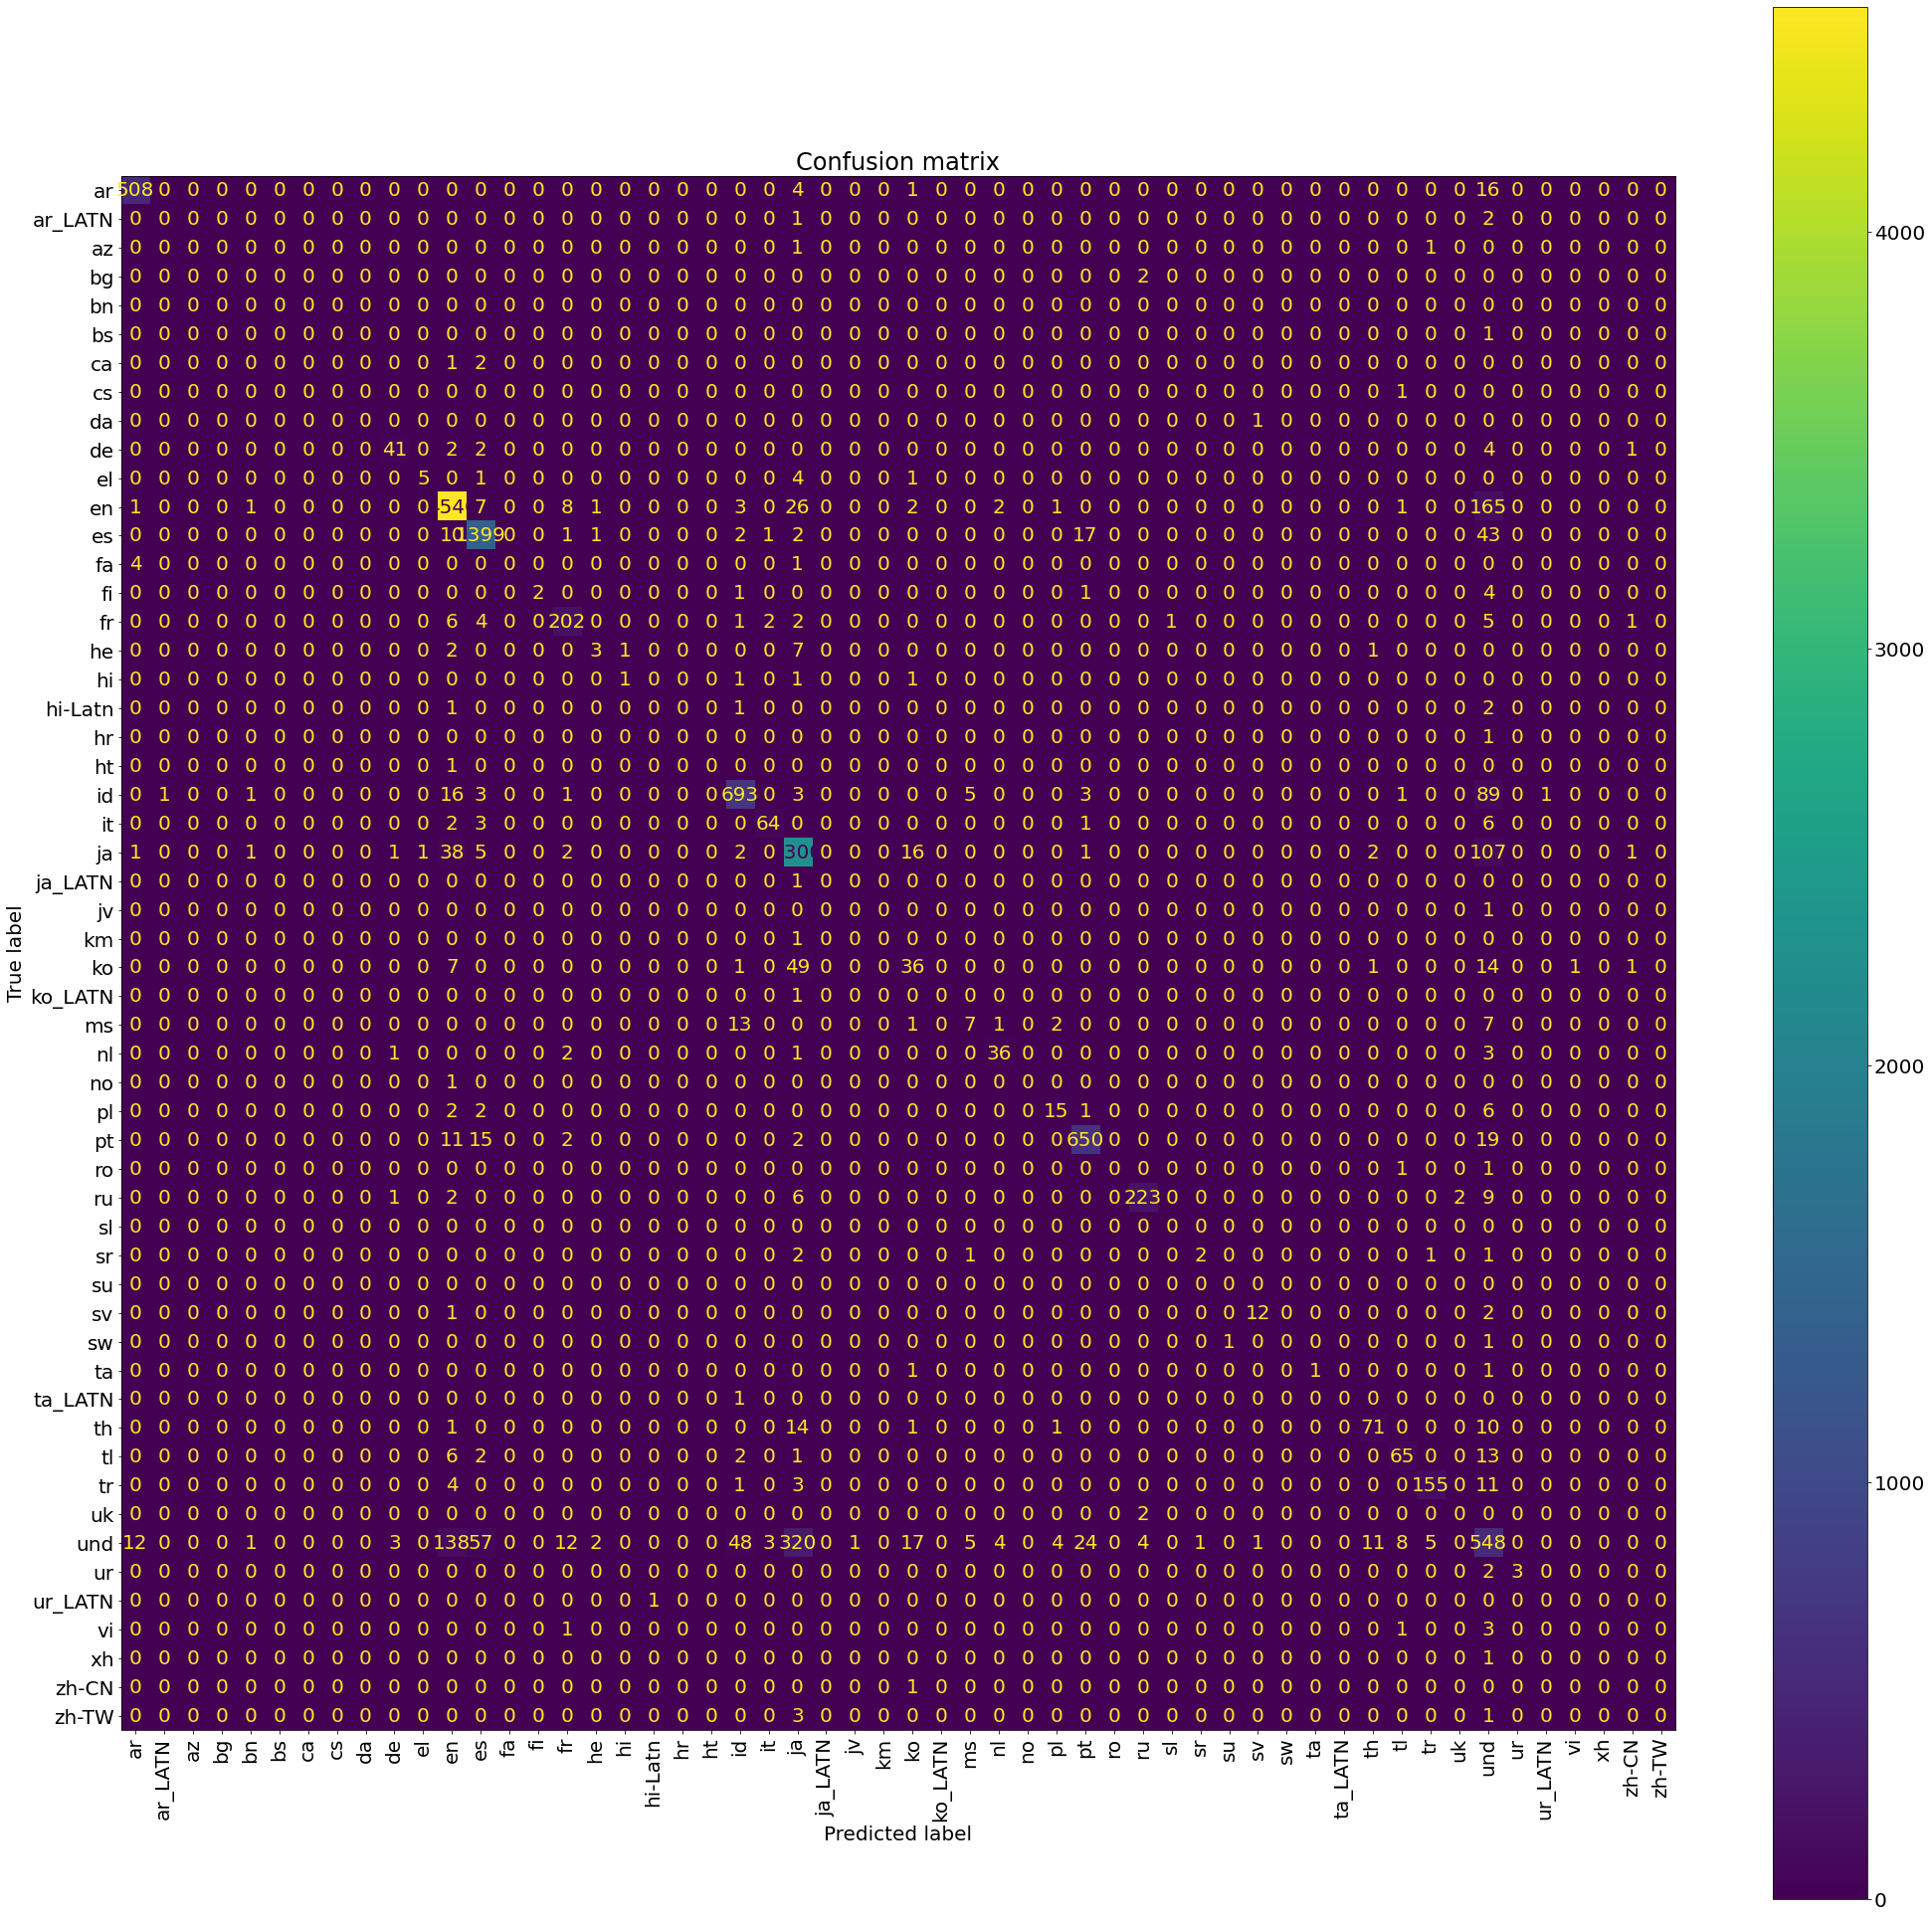

In [ ]:
font = {'size'   : 20}
plt.figure(figsize=(35, 35))
fig, ax = plt.subplots(figsize=(35, 35))
plot_confusion_matrix(grid_search, X_test, y_test, ax=ax)
plt.xticks(rotation=90)
axlabel = ax.get_xticklabels()
new_label = [int(i.get_text()) for i in axlabel]
new_label = label_encoder.inverse_transform(new_label)
ax.yaxis.set_ticklabels(new_label)
ax.xaxis.set_ticklabels(new_label)
plt.rc('font', **font)
plt.title('Confusion matrix')


# Feature importance


In [ ]:
importance = grid_search.best_estimator_.named_steps["logistic"].coef_
importance =  pd.DataFrame(importance.T)
importance.columns = label_encoder.classes_

In [ ]:
#build pipeline to get dictionary
pip1 = Pipeline([
    ('lowercase_transformer',FunctionTransformer(convert_to_lowercase)),
    ('emojies_transformer',FunctionTransformer(remove_emojies)),
    ('url_transformer', FunctionTransformer(remove_urls)),
    ("word_vectorizer", TfidfVectorizer(ngram_range=(1,3), min_df=3)),
])
pip1.fit(X_train)
pip2 = Pipeline([
    ('lowercase_transformer',FunctionTransformer(convert_to_lowercase)),
    ('emojies_transformer',FunctionTransformer(remove_emojies)),
    ('url_transformer', FunctionTransformer(remove_urls)),
    ("char_vectorizer", TfidfVectorizer(analyzer='char', min_df=50,ngram_range=(3,3)))
])
pip2.fit(X_train)
dict1 = pip1.named_steps['word_vectorizer'].vocabulary_
dict2 = pip2.named_steps['char_vectorizer'].vocabulary_
for key in list(dict1.keys()):
  dict1[key] =dict1[key]+2
for key in list(dict2.keys()):
  dict2[key] =dict2[key]+29807+2
d1 = {v: k for k, v in dict1.items()}
d2 = {v:k for k,v in dict2.items()}

In [ ]:
def printImportance(lang):
  print(lang)
  importance_lang =importance[lang].sort_values(ascending=False).head(10)
  for index, item in importance_lang.items():
    if index in d1: print(d1[index],item)
    if index in d2: print(d2[index],item)
  print()

In [ ]:
printImportance('en')
printImportance('es')
printImportance('ja')

en
 th 19.378948801397982
ed  17.64012336963072
's  15.904839182979185
 yo 14.898433564147853
amen 14.54870490930907
test 14.230385313045865
same 13.922981320154106
i'm 13.500896414202494
that 13.441590394648692
nig 12.790439192754642

es
 y  25.16281536148137
os  17.684747980327668
el 17.501098939298195
jaj 17.28246778884834
que 15.823710911520768
as  15.232801654801056
hola 15.10438251005693
bue 13.969192209663058
aja 13.75436607239873
las 12.921715722117712

ja
ました 26.698188141150894
ちゃん 25.504010391310732
かった 24.732490180564735
ってる 23.616427234933028
だから 18.24762123079016
ション 17.352808576327522
いです 17.009564660981667
みたい 16.45737538704375
います 16.176842917047953
まとめ 16.084298388977142

